# Imports

In [2]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

## main func

In [3]:
def main(minutes: int = 5,
         start_pos: np.array = [0.5, 0.5],
         getDF: bool = True):

    Env = Environment()
    Ag = Agent(Env)

    # agent configs
    Ag.pos = start_pos
    Ag.thigmotaxis = 0.2

    for i in range(int(minutes*60/Ag.dt)):
        Ag.update()
    explode_columns = ['pos', 'vel', 'head_direction']
    keep_columns = ['t', 'distance_travelled', 'rot_vel']

    if getDF:
        dfaux = pd.DataFrame(Ag.history)
        dfe = dfaux.explode(explode_columns, ignore_index=True)

        y_pos = [val for val in dfe[['pos']].values[1::2]]
        x_pos = [val for val in dfe[['pos']].values[0::2]]

        y_vel = [val for val in dfe[['vel']].values[1::2]]
        x_vel = [val for val in dfe[['vel']].values[0::2]]

        y_head_direction = [val for val in dfe[['head_direction']].values[1::2]]
        x_head_direction = [val for val in dfe[['head_direction']].values[0::2]]

        df = dfaux[keep_columns].copy()

        df['x_pos'] = [val[0] for val in x_pos]
        df['y_pos'] = [val[0] for val in y_pos]

        df['x_vel'] = [val[0] for val in x_vel]
        df['y_vel'] = [val[0] for val in y_vel]

        df['x_head_direction'] = [val[0] for val in x_head_direction]
        df['y_head_direction'] = [val[0] for val in y_head_direction]

        return df, Ag
    else:
        return Ag.history, Ag

In [4]:
df, ag = main(15,)
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.007719,0.122753,0.507609,0.498705,0.076095,-0.012955,0.985121,-0.171864
1,0.2,0.014517,-1.476528,0.514070,0.496590,0.064607,-0.021144,0.964179,-0.265254
2,0.3,0.020651,-1.798573,0.519465,0.493670,0.053945,-0.029201,0.912926,-0.408125
3,0.4,0.031607,0.939330,0.529547,0.489381,0.100820,-0.042889,0.917808,-0.397024
4,0.5,0.038795,0.659745,0.536332,0.487010,0.067856,-0.023716,0.935811,-0.352502


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


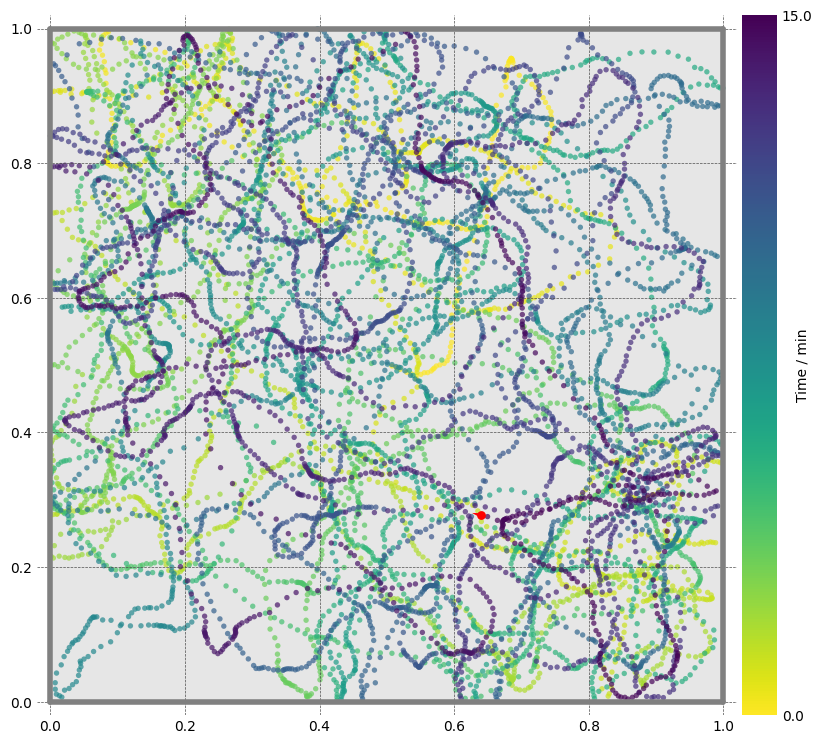

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14,7))
ax = ag.plot_trajectory(color='changing', colorbar=True, gridlines=True,fig=fig, ax=ax)
plt.show()

# Dataset

### feature array

In [6]:
feature_array = []
for x_hd,y_hd, x_vl, y_vl in zip(df['x_head_direction'], df['y_head_direction'], df['x_vel'], df['y_vel'],):
        feature_array.append(torch.tensor([[x_hd, y_hd], [x_vl, y_vl]]))

feature_array = np.array(feature_array)
feature_array = torch.tensor(feature_array)

In [7]:
feature_array[:1], feature_array.shape

(tensor([[[ 0.9851, -0.1719],
          [ 0.0761, -0.0130]]]),
 torch.Size([9000, 2, 2]))

### target_array

In [8]:
target_array = []
for x_pos, y_pos in zip(df['x_pos'],	df['y_pos']):
    target_array.append(torch.tensor([x_pos, y_pos]))
target_array = np.array(target_array)
target_array = torch.tensor(target_array)

In [9]:
target_array[:1], target_array.shape

(tensor([[0.5076, 0.4987]]), torch.Size([9000, 2]))

In [10]:
n = int(len(df)*0.8)
x_train = feature_array[:n]
y_train = target_array[:n]

x_test = feature_array[n:]
y_test = target_array[n:]


print(f"{x_train.shape=}", f"{y_train.shape=}", f"{x_test.shape=}", f"{y_test.shape=}")

x_train.shape=torch.Size([7200, 2, 2]) y_train.shape=torch.Size([7200, 2]) x_test.shape=torch.Size([1800, 2, 2]) y_test.shape=torch.Size([1800, 2])


## train configs

In [11]:
block_size = 5 # 0.5s atras  #MUDAR PRA 10 depois (1s)

x_train[:block_size+1]

tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]],

        [[ 0.9642, -0.2653],
         [ 0.0646, -0.0211]],

        [[ 0.9129, -0.4081],
         [ 0.0539, -0.0292]],

        [[ 0.9178, -0.3970],
         [ 0.1008, -0.0429]],

        [[ 0.9358, -0.3525],
         [ 0.0679, -0.0237]],

        [[ 0.9629, -0.2699],
         [ 0.0772, -0.0181]]])

In [12]:
y_train[:block_size+1]

tensor([[0.5076, 0.4987],
        [0.5141, 0.4966],
        [0.5195, 0.4937],
        [0.5295, 0.4894],
        [0.5363, 0.4870],
        [0.5440, 0.4852]])

## Example Loop

In [13]:
df.head()

,t,distance_travelled,rot_vel,x_pos,y_pos,x_vel,y_vel,x_head_direction,y_head_direction
0,0.1,0.007719,0.122753,0.507609,0.498705,0.076095,-0.012955,0.985121,-0.171864
1,0.2,0.014517,-1.476528,0.514070,0.496590,0.064607,-0.021144,0.964179,-0.265254
2,0.3,0.020651,-1.798573,0.519465,0.493670,0.053945,-0.029201,0.912926,-0.408125
3,0.4,0.031607,0.939330,0.529547,0.489381,0.100820,-0.042889,0.917808,-0.397024
4,0.5,0.038795,0.659745,0.536332,0.487010,0.067856,-0.023716,0.935811,-0.352502


In [14]:
x_exemple = x_train[:block_size]
y_example = y_train[1:block_size+1]
for t in range(block_size):
    context = x_exemple[:t+1]
    target = y_example[t]
    print(f"when input is:")
    print(context)
    print('the target: ')
    print(target)

when input is:
tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]]])
the target: 
tensor([0.5141, 0.4966])
when input is:
tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]],

        [[ 0.9642, -0.2653],
         [ 0.0646, -0.0211]]])
the target: 
tensor([0.5195, 0.4937])
when input is:
tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]],

        [[ 0.9642, -0.2653],
         [ 0.0646, -0.0211]],

        [[ 0.9129, -0.4081],
         [ 0.0539, -0.0292]]])
the target: 
tensor([0.5295, 0.4894])
when input is:
tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]],

        [[ 0.9642, -0.2653],
         [ 0.0646, -0.0211]],

        [[ 0.9129, -0.4081],
         [ 0.0539, -0.0292]],

        [[ 0.9178, -0.3970],
         [ 0.1008, -0.0429]]])
the target: 
tensor([0.5363, 0.4870])
when input is:
tensor([[[ 0.9851, -0.1719],
         [ 0.0761, -0.0130]],

        [[ 0.9642, -0.2653],
         [ 0.0646, -0.0211]],

        [[ 0.9129, -0.4081],
         [ 0.0539, -0.02

# Building Blocks

In [15]:
torch.manual_seed(1337)
batch_size = 1 # how many independent sequences will we process in parallel?
block_size = 10 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == 'train':
        x_data, y_data = x_train, y_train
    else:
        x_data, y_data = x_test, y_test
    ix = torch.randint(len(x_data) - block_size, (batch_size,))
    x = torch.stack([x_data[i:i+block_size] for i in ix])
    y = torch.stack([y_data[i+1:i+block_size+1] for i in ix])
    return x, y

In [16]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

inputs:
torch.Size([1, 10, 2, 2])
tensor([[[[ 5.6531e-01, -8.2488e-01],
          [ 4.6854e-02, -7.9054e-02]],

         [[ 4.5494e-01, -8.9052e-01],
          [ 5.5395e-02, -1.2809e-01]],

         [[ 6.5817e-01, -7.5287e-01],
          [ 7.4317e-02, -6.6547e-02]],

         [[ 4.7690e-01, -8.7896e-01],
          [ 5.2164e-02, -1.2793e-01]],

         [[ 5.2910e-01, -8.4856e-01],
          [ 8.6772e-02, -1.3024e-01]],

         [[ 4.6649e-01, -8.8453e-01],
          [ 6.9633e-02, -1.4443e-01]],

         [[ 5.2779e-01, -8.4938e-01],
          [ 5.0155e-02, -7.4696e-02]],

         [[ 3.8499e-01, -9.2292e-01],
          [ 2.0645e-02, -6.3344e-02]],

         [[ 2.7097e-01, -9.6259e-01],
          [ 1.8459e-02, -8.4888e-02]],

         [[ 9.0026e-02, -9.9594e-01],
          [-1.0292e-04, -6.4812e-02]]]])
targets:
torch.Size([1, 10, 2])
tensor([[[0.1414, 0.8209],
         [0.1488, 0.8143],
         [0.1540, 0.8015],
         [0.1627, 0.7884],
         [0.1696, 0.7740],
         [0.1747, 

In [17]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

when input is [[[0.5653083920478821, -0.8248796463012695], [0.046853888779878616, -0.07905428111553192]]] the target: tensor([0.1414, 0.8209])
when input is [[[0.5653083920478821, -0.8248796463012695], [0.046853888779878616, -0.07905428111553192]], [[0.45494356751441956, -0.8905202746391296], [0.05539523437619209, -0.12808622419834137]]] the target: tensor([0.1488, 0.8143])
when input is [[[0.5653083920478821, -0.8248796463012695], [0.046853888779878616, -0.07905428111553192]], [[0.45494356751441956, -0.8905202746391296], [0.05539523437619209, -0.12808622419834137]], [[0.658174455165863, -0.7528654336929321], [0.07431672513484955, -0.06654730439186096]]] the target: tensor([0.1540, 0.8015])
when input is [[[0.5653083920478821, -0.8248796463012695], [0.046853888779878616, -0.07905428111553192]], [[0.45494356751441956, -0.8905202746391296], [0.05539523437619209, -0.12808622419834137]], [[0.658174455165863, -0.7528654336929321], [0.07431672513484955, -0.06654730439186096]], [[0.4769046604

## attention mechanism

In [18]:
torch.manual_seed(1337)

F, L, C = 4, 8, 32 # # de (F)olhas,  # de (L)inhas e # de (C)olunas
head_size = 16
x = x_train[:F*L*C].reshape(F, L, C, 2, 2)
four_linear = nn.Linear(4, 1, bias=False) # going from x_hd, y_hd, x_vl, y_vl to one number
x_ = four_linear(x.reshape(F, L, C, 4))
x_ = x_.reshape(F, L, C)
x_.shape

torch.Size([4, 8, 32])

###  k, q linears

In [19]:
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

In [20]:
k = key(x_)
q = query(x_)

In [21]:
k.shape, k.transpose(-2, -1).shape

(torch.Size([4, 8, 16]), torch.Size([4, 16, 8]))

In [22]:
# Vamos trocar a segunda com a terceira dimensao da matriz de keys para conseguirmos multiplicar as duas

In [23]:
wei_no_head_norm = q @ k.transpose(-2, -1) # (F, L, head_size) @ (F, head_size, L) => (F, L, L)
wei_head_norm = q @ k.transpose(-2, -1) * head_size **-0.5 # normalizando os pesos ( deixando a da multiplicacao menor que de cada matriz k e q)

wei = q @ k.transpose(-2, -1) * head_size **-0.5
wei.shape

torch.Size([4, 8, 8])

In [24]:
f"{k.var(), q.var(), wei_no_head_norm.var()}", f"{k.var(), q.var(), wei_head_norm.var()}"

('(tensor(0.0319, grad_fn=<VarBackward0>), tensor(0.0365, grad_fn=<VarBackward0>), tensor(0.0217, grad_fn=<VarBackward0>))',
 '(tensor(0.0319, grad_fn=<VarBackward0>), tensor(0.0365, grad_fn=<VarBackward0>), tensor(0.0014, grad_fn=<VarBackward0>))')

In [25]:
wei[0,:,:]

tensor([[-0.0201, -0.0067, -0.0256, -0.0147,  0.0192, -0.0216,  0.0017,  0.0077],
        [ 0.0405,  0.0070,  0.0231, -0.0308, -0.0331, -0.0160,  0.0393,  0.0187],
        [-0.0704, -0.0143, -0.0391,  0.0467,  0.0645,  0.0103, -0.0602, -0.0328],
        [-0.0070, -0.0021,  0.0239,  0.0308,  0.0109,  0.0121, -0.0213, -0.0213],
        [-0.0167, -0.0014,  0.0025,  0.0401,  0.0126,  0.0361, -0.0345, -0.0240],
        [ 0.0257,  0.0117,  0.0060, -0.0342, -0.0245, -0.0171,  0.0355,  0.0197],
        [-0.0028, -0.0067, -0.0102, -0.0149,  0.0057, -0.0381,  0.0132,  0.0099],
        [ 0.0239,  0.0003, -0.0047, -0.0364, -0.0228, -0.0186,  0.0327,  0.0260]],
       grad_fn=<SliceBackward0>)

In [26]:
tril = torch.tril(torch.ones(L, L))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [45]:
tril.shape

torch.Size([8, 8])

In [27]:
wei_masked = wei.masked_fill(tril == 0, float('-inf'))
wei.masked_fill(tril == 0, float('-inf'))[0,:,:]

tensor([[-0.0201,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.0405,  0.0070,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0704, -0.0143, -0.0391,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0070, -0.0021,  0.0239,  0.0308,    -inf,    -inf,    -inf,    -inf],
        [-0.0167, -0.0014,  0.0025,  0.0401,  0.0126,    -inf,    -inf,    -inf],
        [ 0.0257,  0.0117,  0.0060, -0.0342, -0.0245, -0.0171,    -inf,    -inf],
        [-0.0028, -0.0067, -0.0102, -0.0149,  0.0057, -0.0381,  0.0132,    -inf],
        [ 0.0239,  0.0003, -0.0047, -0.0364, -0.0228, -0.0186,  0.0327,  0.0260]],
       grad_fn=<SliceBackward0>)

In [28]:
nn.functional.softmax(wei, dim=1)[0,:,:]

tensor([[0.1229, 0.1244, 0.1222, 0.1233, 0.1268, 0.1231, 0.1250, 0.1259],
        [0.1305, 0.1261, 0.1283, 0.1213, 0.1204, 0.1238, 0.1298, 0.1273],
        [0.1168, 0.1234, 0.1205, 0.1311, 0.1327, 0.1271, 0.1175, 0.1209],
        [0.1245, 0.1249, 0.1284, 0.1291, 0.1258, 0.1273, 0.1222, 0.1223],
        [0.1233, 0.1250, 0.1257, 0.1303, 0.1260, 0.1304, 0.1206, 0.1220],
        [0.1286, 0.1267, 0.1261, 0.1209, 0.1214, 0.1237, 0.1293, 0.1274],
        [0.1250, 0.1244, 0.1241, 0.1233, 0.1252, 0.1211, 0.1265, 0.1261],
        [0.1284, 0.1252, 0.1248, 0.1207, 0.1216, 0.1235, 0.1290, 0.1282]],
       grad_fn=<SliceBackward0>)

In [29]:
wei_masked_softmax = nn.functional.softmax(wei_masked, dim=1)
nn.functional.softmax(wei_masked, dim=1)[0,:,:]

tensor([[0.1229, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1305, 0.1440, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1168, 0.1409, 0.1608, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1245, 0.1427, 0.1713, 0.2068, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1233, 0.1428, 0.1677, 0.2087, 0.2550, 0.0000, 0.0000, 0.0000],
        [0.1286, 0.1446, 0.1682, 0.1937, 0.2457, 0.3358, 0.0000, 0.0000],
        [0.1250, 0.1420, 0.1655, 0.1975, 0.2532, 0.3288, 0.4951, 0.0000],
        [0.1284, 0.1430, 0.1665, 0.1933, 0.2461, 0.3353, 0.5049, 1.0000]],
       grad_fn=<SliceBackward0>)

In [42]:
dropout_value = 0.5
dropout_ = nn.Dropout(dropout_value)

In [32]:
dropout_(wei_masked_softmax)[0,:,:]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2337, 0.0000, 0.3217, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2490, 0.0000, 0.3425, 0.4135, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2466, 0.2855, 0.3353, 0.4174, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2572, 0.2893, 0.0000, 0.0000, 0.4914, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2840, 0.3311, 0.3950, 0.5065, 0.6577, 0.9902, 0.0000],
        [0.2568, 0.0000, 0.3329, 0.0000, 0.4922, 0.6707, 0.0000, 0.0000]],
       grad_fn=<SliceBackward0>)

In [38]:
wei_masked_softmax_drop = dropout_(wei_masked_softmax)
wei_masked_softmax_drop.shape

torch.Size([4, 8, 8])

In [39]:
v = value(x_)
v.shape

torch.Size([4, 8, 16])

In [37]:
# out
view_out = wei_masked_softmax_drop @ v
view_out.shape

torch.Size([4, 8, 16])

In [40]:
view_out[0,:,:]

tensor([[-0.0206, -0.0595, -0.0443, -0.0184,  0.0073,  0.0183,  0.0228, -0.0287,
          0.0032,  0.0064, -0.0453,  0.0196,  0.0507,  0.0376,  0.0529,  0.0280],
        [-0.0177, -0.0925, -0.0528, -0.0489, -0.0036,  0.0641,  0.0012, -0.0507,
          0.0287,  0.0308, -0.0976,  0.0229,  0.0533,  0.0300,  0.0663,  0.0410],
        [-0.0314, -0.0536, -0.1037,  0.0007,  0.0255,  0.0429,  0.0695, -0.0707,
          0.0068,  0.0052, -0.0940,  0.0479,  0.1121,  0.0726,  0.1255,  0.0451],
        [-0.0074,  0.2372, -0.0427,  0.1002,  0.0909, -0.1002,  0.1450,  0.0156,
         -0.0070, -0.1428,  0.1003,  0.0390,  0.0050,  0.0345,  0.0142, -0.0552],
        [ 0.0288,  0.1299,  0.0560,  0.0785, -0.0209, -0.0379,  0.0104,  0.0276,
          0.0064, -0.0444,  0.0816, -0.0130, -0.0894, -0.0482, -0.0819, -0.0419],
        [-0.0239,  0.1376,  0.1009,  0.1204, -0.0795, -0.0996,  0.0013,  0.0737,
          0.0817, -0.1210, -0.0361,  0.0467,  0.0163, -0.0493,  0.0340,  0.0455],
        [-0.0037,  0.3

In [41]:
out = wei_masked_softmax_drop @ v

In [46]:
C

32

In [53]:
ff_lin1 = nn.Linear(C//2, 2*C)
ff_relu = nn.ReLU()
ff_lin2 = nn.Linear(2*C, C//2)
ff_drop = nn.Dropout(dropout_value)

In [58]:
print(ff_lin1(out).shape)
out_lin1 = ff_lin1(out)
ff_lin1(out)[0,0,:]

torch.Size([4, 8, 64])


tensor([ 0.0441, -0.1538, -0.1680, -0.0539,  0.2354,  0.0244,  0.0179, -0.1146,
        -0.0800,  0.1163, -0.2294, -0.1132,  0.1543, -0.2411,  0.1959,  0.1038,
        -0.0433, -0.2260,  0.1515, -0.0281,  0.0077, -0.2461,  0.0893, -0.0828,
        -0.0758, -0.2207, -0.1284, -0.0159,  0.2290, -0.0336, -0.2227, -0.2241,
         0.2117,  0.0580, -0.2093,  0.1656,  0.1501, -0.0266,  0.1527,  0.0891,
        -0.0509,  0.1090, -0.0130,  0.1492,  0.1128,  0.0900, -0.2192, -0.2016,
         0.0500,  0.0004, -0.2284, -0.0438,  0.1661,  0.1509,  0.0896,  0.2212,
         0.0878,  0.0733, -0.0863,  0.0009, -0.1302,  0.0297,  0.1869, -0.0025],
       grad_fn=<SliceBackward0>)

In [60]:
print(ff_relu(out_lin1).shape)
out_lin1_relu = ff_relu(out_lin1)
ff_relu(out_lin1)[0,0,:]

torch.Size([4, 8, 64])


tensor([0.0441, 0.0000, 0.0000, 0.0000, 0.2354, 0.0244, 0.0179, 0.0000, 0.0000,
        0.1163, 0.0000, 0.0000, 0.1543, 0.0000, 0.1959, 0.1038, 0.0000, 0.0000,
        0.1515, 0.0000, 0.0077, 0.0000, 0.0893, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.2290, 0.0000, 0.0000, 0.0000, 0.2117, 0.0580, 0.0000, 0.1656,
        0.1501, 0.0000, 0.1527, 0.0891, 0.0000, 0.1090, 0.0000, 0.1492, 0.1128,
        0.0900, 0.0000, 0.0000, 0.0500, 0.0004, 0.0000, 0.0000, 0.1661, 0.1509,
        0.0896, 0.2212, 0.0878, 0.0733, 0.0000, 0.0009, 0.0000, 0.0297, 0.1869,
        0.0000], grad_fn=<SliceBackward0>)

In [62]:
print(ff_lin2(out_lin1_relu).shape)
out_lin1_relu_lin2 = ff_lin2(out_lin1_relu)
ff_lin2(out_lin1_relu)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.0354,  0.0024,  0.0069, -0.0706, -0.0446,  0.1190,  0.1117, -0.0850,
         0.0533,  0.0139,  0.0256, -0.1240, -0.0360,  0.1248, -0.1160,  0.0550],
       grad_fn=<SliceBackward0>)

In [63]:
print(ff_drop(out_lin1_relu_lin2).shape)
out_lin1_relu_lin2_drop = ff_drop(out_lin1_relu_lin2)
ff_drop(out_lin1_relu_lin2)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.0708,  0.0000,  0.0139, -0.0000, -0.0893,  0.2380,  0.0000, -0.1700,
         0.1066,  0.0000,  0.0000, -0.2481, -0.0721,  0.2496, -0.2320,  0.0000],
       grad_fn=<SliceBackward0>)

In [64]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
             nn.Linear(n_embd//2, 2*n_embd),
             nn.ReLU(),
             nn.Linear(2*n_embd, n_embd//2),
             nn.Dropout(dropout_value),
        )

    def forward(self, x):
        return self.net(x)

In [65]:
feedforward = FeedFoward(C)

In [68]:
print(feedforward(out).shape)
feedforward(out)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.0185, -0.0000, -0.0512,  0.0735, -0.0754,  0.0000, -0.4039, -0.0060,
        -0.0000,  0.0000,  0.0000, -0.0000, -0.1722, -0.0000, -0.3119,  0.0000],
       grad_fn=<SliceBackward0>)

In [69]:
# full copied
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# torch.manual_seed(1337)
# module = LayerNorm1d(100)
# x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
# x = module(x)
# x.shape

In [74]:
lay_norm = LayerNorm1d(C//2)

In [76]:
print(lay_norm(out).shape)
lay_norm(out)[0,0,:]

torch.Size([4, 8, 16])


tensor([ 0.4852,  0.2225,  0.6116,  0.2960,  0.0400, -0.3574,  0.1205,  0.6509,
        -0.2088, -0.2349,  0.4183, -0.1971, -0.4469, -0.4134, -0.5691, -0.3213],
       grad_fn=<SliceBackward0>)

### head class

In [77]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embd, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

### block class

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = Head(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
        #self.four_linear = nn.Linear(4, 1, bias=False) # going from x_hd, y_hd, x_vl, y_vl to one number